In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!pip install controlnet_aux
!pip install diffusers transformers accelerate
!pip install huggingface_hub
!pip install ipywidgets==7.7.1
from huggingface_hub import notebook_login
notebook_login()

Mounted at /content/drive
/content/drive/MyDrive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.2 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [ ]:

# openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')


# image = openpose(image)

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "botp/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)


pipe.enable_model_cpu_offload()
# openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')

# image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-openpose/resolve/main/images/pose.png")

# image = openpose(image)

# image.save('poseoutput.png')

# image = load_image("test.png")

image = load_image("/content/test2.png")

image = pipe("a set of 4 images of the same person in the same scene. \
            The top left image shows a from behind at an angle. \
            The top right image shows that person from behind and slightly above. \
            The bottom left image shows the person with their left side mostly facing the camera. \
            The bottom right image is front facing. \
            The person is an old woman. The scene is a garden.",
             image, num_inference_steps=200).images[0]

image.save('test_pose_out.png')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
Token indices sequence length is longer than the specified maximum sequence length for this model (78 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['.']


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
#image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-openpose/resolve/main/images/pose.png")
#image = load_image('/content/pose_2024_09_11_12_37_28.png')
#image = load_image('/content/drive/MyDrive/test.png')
image = load_image("/content/test2.png")
negative_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, streaks'
image = pipe("4 images of the same person in the same scene. \
            The images are different angles of someone standing completely still. \
            Top left shows them from behind at an angle. \
            Top right shows them from behind and slightly above. \
            Bottom left shows them with their left side mostly facing the camera. \
            Bottom right is front facing. \
            The person is a cowboy. The scene is a parking lot.",
             image,
             num_inference_steps=200,
             negative_prompt=negative_prompt,
            controlnet_conditioning_scale=2.0).images[0]

image.save('test_pose_out.png')

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from diffusers import DDIMScheduler, EulerAncestralDiscreteScheduler
from controlnet_aux import OpenposeDetector
from PIL import Image
import torch
import numpy as np
import cv2



controlnet_conditioning_scale = 7.0
prompt = "4 images of the same person in the same scene. \
            The images are frames from video of someone standing completely still. \
            Top left shows them from behind at an angle. \
            Top right shows them from behind and slightly above. \
            Bottom left shows them with their left side mostly facing the camera. \
            Bottom right is front facing. \
            They are a handsome man. The scene is a parking lot."
negative_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'



eulera_scheduler = EulerAncestralDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="scheduler")


controlnet = ControlNetModel.from_pretrained(
    "xinsir/controlnet-openpose-sdxl-1.0",
    torch_dtype=torch.float16
)

# when test with other base model, you need to change the vae also.
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)


pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
    scheduler=eulera_scheduler,
)

# processor = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')


# controlnet_img = cv2.imread("your image path")
# controlnet_img = processor(controlnet_img, hand_and_face=False, output_type='cv2')

controlnet_img = cv2.imread("test.png")

# need to resize the image resolution to 1024 * 1024 or same bucket resolution to get the best performance
height, width, _  = controlnet_img.shape
ratio = np.sqrt(1024. * 1024. / (width * height))
new_width, new_height = int(width * ratio), int(height * ratio)
controlnet_img = cv2.resize(controlnet_img, (new_width, new_height))
controlnet_img = Image.fromarray(controlnet_img)

images = pipe(
    prompt,
    negative_prompt=negative_prompt,
    image=controlnet_img,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    width=new_width,
    height=new_height,
    num_inference_steps=30,
    ).images

images[0].save(f'test_pose_out.png')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
controlnet_conditioning_scale = 7.0
prompt = "4 images of the exact same person in the exact same scene taken from different angles. \
            The images are frames from a panning video of someone standing completely still. \
            Top left shows the person from behind at an angle. \
            Top right shows the person from behind and slightly above. \
            Bottom left shows the person with their left side mostly facing the camera. \
            Bottom right shows the person with the camera facing their front. \
            The person is a handsome man. The scene is a parking lot."
negative_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'

controlnet_img = cv2.imread("test.png")

# need to resize the image resolution to 1024 * 1024 or same bucket resolution to get the best performance
height, width, _  = controlnet_img.shape
ratio = np.sqrt(1024. * 1024. / (width * height))
new_width, new_height = int(width * ratio), int(height * ratio)
controlnet_img = cv2.resize(controlnet_img, (new_width, new_height))
controlnet_img = Image.fromarray(controlnet_img)

images = pipe(
    prompt,
    negative_prompt=negative_prompt,
    image=controlnet_img,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    width=new_width,
    height=new_height,
    num_inference_steps=30,
    ).images

images[0].save(f'test_pose_out.png')

An error occurred while trying to fetch thibaud/controlnet-openpose-sdxl-1.0: thibaud/controlnet-openpose-sdxl-1.0 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (91 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the person is a handsome man. the scene is a parking lot.']
Token indices sequence length is longer than the specified maximum sequence length for this model (91 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the person is a handsome man. the scene is a parking lot.']


  0%|          | 0/250 [00:00<?, ?it/s]

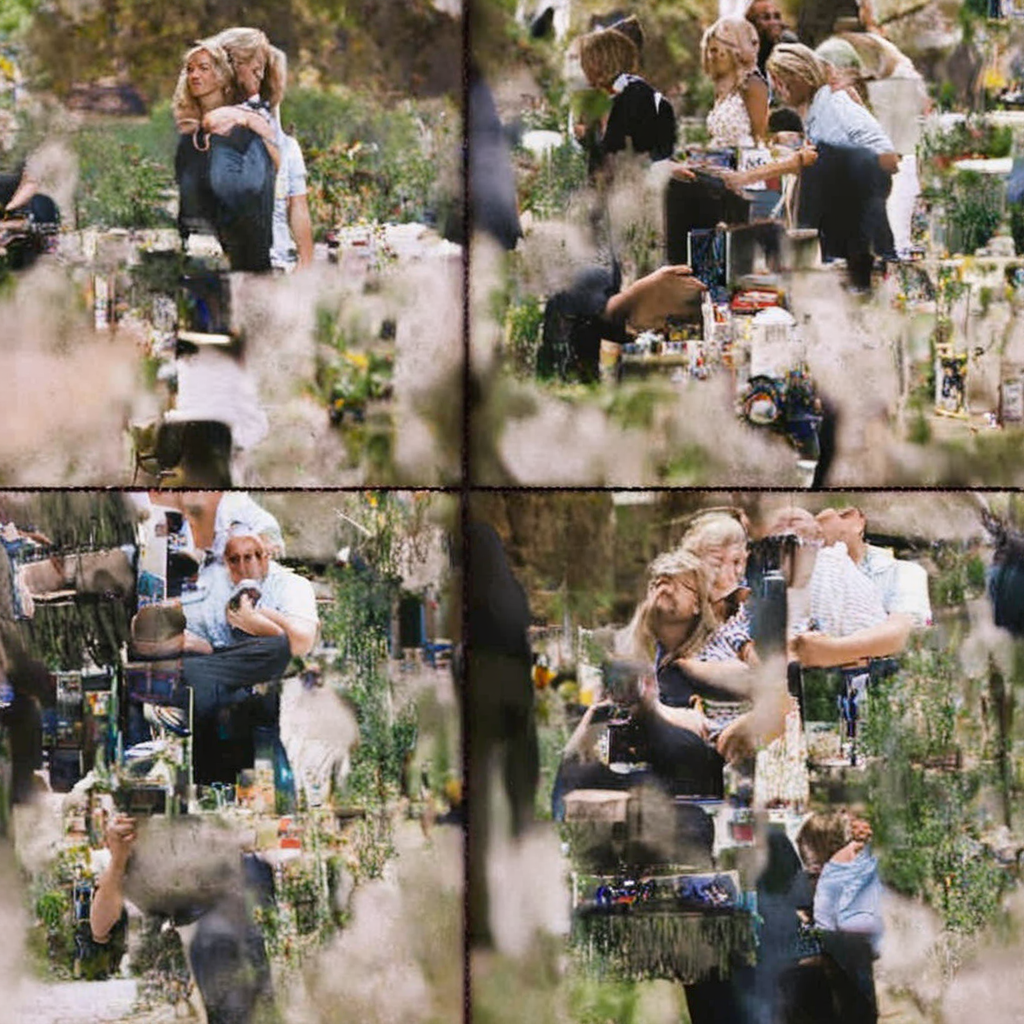

In [ ]:
from diffusers import AutoencoderKL, StableDiffusionXLControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image


# # Compute openpose conditioning image.
# openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# image = load_image(
#     "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
# )
openpose_image = load_image("/content/test2.png")

# Initialize ControlNet pipeline.
controlnet = ControlNetModel.from_pretrained("thibaud/controlnet-openpose-sdxl-1.0", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.enable_model_cpu_offload()


# Infer.
prompt = "4 images of the same person in the same scene taken from different angles. \
            The images are frames from a video of someone standing still. \
            Top left shows the person from behind at an angle. \
            Top right shows the person from behind and slightly above. \
            Bottom left shows the person with their left side mostly facing the camera. \
            Bottom right shows the person with the camera facing their front. \
            The person is a handsome man. The scene is a parking lot."
negative_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'
controlnet_conditioning_scale = 2.0

images = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=250,
    num_images_per_prompt=4,
    image=openpose_image.resize((1024, 1024)),
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    generator=torch.manual_seed(97),
).images
images[0]